In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from numpy.linalg import inv
from aux import *

In [2]:
np.random.seed(42)
N=10
w_orig = np.array([-3.0, 2.0])
x = np.random.uniform(-1, 1, N)
beta = 2.0 # noize precision (inverse variance)
PHI =np.vstack((x,np.ones(x.shape[0]))).T # x with additional columns with ones
noize = np.random.normal(0.0, scale=1.0/np.sqrt(beta), size=N)
t = PHI@w_orig + noize # target

### Frequentists' approach

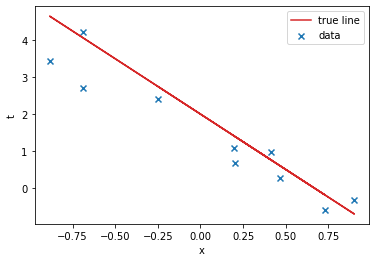

In [3]:
plt.scatter(x,t, marker="x", label="data")
plt.plot(x,PHI.dot(w_orig), c="tab:red", label="true line")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.savefig("data.png", dpi=500)
plt.show()

In [4]:
w_ml = (inv(PHI.T.dot(PHI))).dot(PHI.T.dot(t))
beta_ml = N/np.sum((t-PHI.dot(w_ml))**2)

In [5]:
print("True parameters:", *w_orig)
print("Parameters:", *w_ml)
print("Noize variance: ", 1/beta_ml)

True parameters: -3.0 2.0
Parameters: -2.4663686727238 1.5886689014312432
Noize variance:  0.1998306381126754


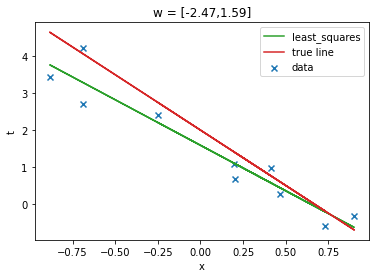

In [6]:
# plt.fill_between(np.sort(x),y1=(PHI.dot(w_ml)+stats.norm.ppf(0.975, scale=1/np.sqrt(beta_ml)))[np.argsort(x)],
#                  y2=(PHI.dot(w_ml)-stats.norm.ppf(0.975, scale=1/np.sqrt(beta_ml)))[np.argsort(x)],
#                  color="tab:red", alpha=0.3, label="95% interval")
plt.scatter(x, t, marker="x", label="data")
plt.plot(x,PHI.dot(w_ml), c="tab:green", label="least_squares")
plt.plot(x,PHI.dot(w_orig), c="tab:red", label="true line")
plt.xlabel("x")
plt.ylabel("t")
plt.title(f"w = [{round(w_ml[0],2)},{round(w_ml[1],2)}]")
plt.legend()
plt.savefig("../img/linreg/fited-ml.png", dpi=500)
plt.show()

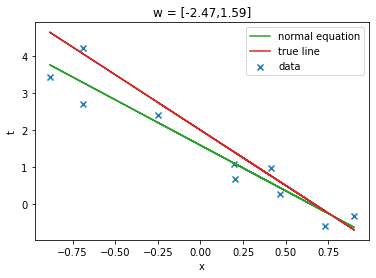

In [7]:
np.random.seed(42)
N=10
w_orig = np.array([-3.0, 2.0]) # true values of the parameter
x = np.random.uniform(-1, 1, N)
beta = 2.0 # noize precision (inverse variance)
PHI =np.vstack((x,np.ones(x.shape[0]))).T # x with additional columns with ones
noize = np.random.normal(0.0, scale=1.0/np.sqrt(beta), size=N)
t = PHI@w_orig + noize # target

w_ml = (inv(PHI.T.dot(PHI))).dot(PHI.T.dot(t)) # normal equation

plt.scatter(x, t, marker="x", label="data")
plt.plot(x,PHI.dot(w_ml), c="tab:green", label="normal equation")
plt.plot(x,PHI.dot(w_orig), c="tab:red", label="true line")
plt.xlabel("x")
plt.ylabel("t")
plt.title(f"w = [{round(w_ml[0],2)},{round(w_ml[1],2)}]")
plt.legend()
plt.show()

#### Sequential learning

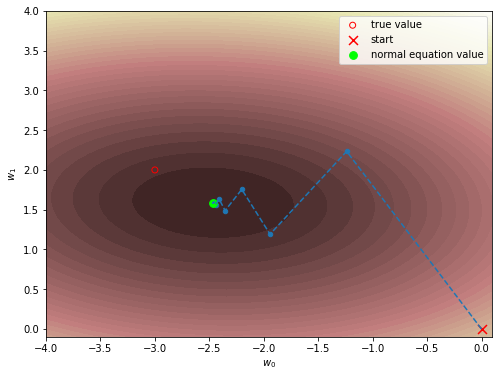

In [8]:
w0 = np.array([0.0, 0.0])[np.newaxis,:] # first guess
eta = 0.15 # learning rate

xc = np.linspace(-4,0.1, 100)
yc = np.linspace(-0.1, 4, 100)

X, Y = np.meshgrid(xc, yc)
www = np.moveaxis(np.stack((X,Y)), 0, -1)
Z = np.sum((t - www.dot(PHI.T))**2, axis=-1)

for _ in range(50):
    w0 = np.vstack((w0, w0[-1] + eta*(t-w0[-1].dot(PHI.T)).dot(PHI)))
    
plt.figure(figsize=(8,6))
plt.contourf(X, Y, Z,50, cmap='pink')
plt.scatter(*w_orig, facecolors='none', edgecolors='r', label="true value")
plt.scatter(w0[1:,0], w0[1:,1], s=20)
plt.plot(w0[:,0], w0[:,1],"--")
plt.scatter(*w0[0], label="start", marker='x', color='red', s=80)
plt.scatter(*w_ml, facecolors='none', c='lime',s=60, label="normal equation value")
plt.xlabel("$w_0$")
plt.ylabel("$w_1$")
plt.legend()
plt.savefig("../img/linreg/descent.png", dpi=500)
plt.show()

### Bayesian approach

In [9]:
m0 = np.array([0,0])
S0 = np.array([[10,0],[0,10]])
w0 = np.linspace(-5,5,100)
w1 = np.linspace(-5,5,100)
w=np.array([[[val0,val1] for val0 in w0] for val1 in w1])
pr = prior(w, m0, S0)

In [10]:
n=1
data_x = x
data_PHI = PHI
data_y = t

In [11]:
beta = 2.0
S1 = inv(inv(S0) + beta*data_PHI.T.dot(data_PHI))
m1 = S1.dot(inv(S0).dot(m0) + beta*data_PHI.T.dot(data_y))

In [12]:
lk = likelihood(w, data_y, data_PHI, beta)
m1, S1 = m1_S1(m0, S0, data_y, beta, data_PHI)
pr1 = prior(w, m1, S1)

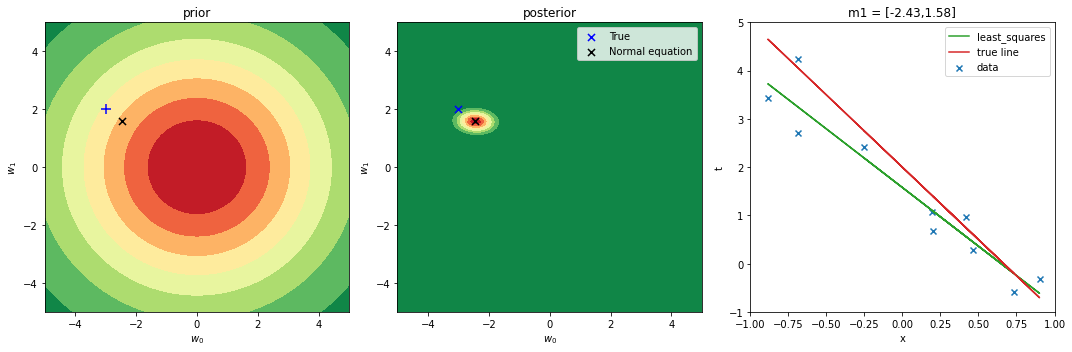

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.contourf(w0, w1, pr, cmap='RdYlGn_r')
plt.scatter(*w_orig, marker="+", s=100, c="b", label="true value")
plt.scatter(*w_ml, marker='x', c='black', s=50)
plt.xlabel("$w_0$")
plt.ylabel("$w_1$")
plt.title("prior")
plt.subplot(132)
plt.contourf(w0,w1,pr1, cmap='RdYlGn_r')
plt.scatter(*w_orig, marker='x', c='b', s=50, label="True")
plt.scatter(*w_ml, marker='x', c='black', s=50, label="Normal equation")
plt.legend()
plt.title("posterior")
plt.xlabel("$w_0$")
plt.ylabel("$w_1$")
plt.subplot(133)
plt.scatter(x, t, marker='x', label='data')
plt.plot(x,PHI.dot(m1), c="tab:green", label="least_squares")
plt.plot(x,PHI.dot(w_orig), c="tab:red", label="true line")
plt.title(f"m1 = [{round(m1[0],2)},{round(m1[1],2)}]")
plt.legend()
plt.xlabel("x")
plt.ylabel("t")
plt.xlim([-1,1])
plt.ylim([-1,5])
plt.tight_layout()
plt.savefig("../img/linreg/bayesian_fit.png", dpi=500)
plt.show()

In [14]:
# import scipy

In [92]:
# def likelihood(w, t, PHI, beta):
#     if t.shape:
#         return np.prod(scipy.stats.norm.pdf(t,loc=w.dot(PHI.T), scale=1.0/np.sqrt(beta)), axis=-1)
#     else:
#         return scipy.stats.norm.pdf(t,loc=w.dot(PHI.T), scale=1.0/np.sqrt(beta))
    
# def m1_S1(m0, S0, y, beta, PHI):
#     if y.shape:
#         S1 = np.linalg.inv(np.linalg.inv(S0) + beta*PHI.T@PHI)
#         m1 = S1.dot(np.linalg.inv(S0).dot(m0) + beta*PHI.T.dot(y))
#     else:
#         S1 = np.linalg.inv(np.linalg.inv(S0) + beta*PHI[np.newaxis].T@PHI[np.newaxis])
#         m1 = S1.dot(np.linalg.inv(S0).dot(m0) + beta*PHI.T*y)
#     return m1, S1

# m0 = np.array([0,0])
# S0 = np.array([[10,0],[0,10]])
# w0 = np.linspace(-5,5,100)
# w1 = np.linspace(-5,5,100)
# w=np.array([[[val0,val1] for val0 in w0] for val1 in w1])
# pr = scipy.stats.multivariate_normal.pdf(w,mean=m0, cov=S0)

# lk = likelihood(w, t, PHI, beta)
# m1, S1 = m1_S1(m0, S0, t, beta, PHI)
# pr1 = scipy.stats.multivariate_normal.pdf(w,mean=m1, cov=S1)

# plt.figure(figsize=(15,5))
# plt.subplot(131)
# plt.contourf(w0, w1, pr, cmap='RdYlGn_r')
# plt.scatter(*w_orig, marker="+", s=100, c="b", label="true value")
# plt.scatter(*w_ml, marker='x', c='black', s=50)
# plt.xlabel("$w_0$")
# plt.ylabel("$w_1$")
# plt.title("prior")
# plt.subplot(132)
# plt.contourf(w0,w1,pr1, cmap='RdYlGn_r')
# plt.scatter(*w_orig, marker='x', c='b', s=50, label="True")
# plt.scatter(*w_ml, marker='x', c='black', s=50, label="Normal equation")
# plt.legend()
# plt.title("posterior")
# plt.xlabel("$w_0$")
# plt.ylabel("$w_1$")
# plt.subplot(133)
# plt.scatter(x, t, marker='x', label='data')
# plt.plot(x,PHI.dot(m1), c="tab:green", label="least_squares")
# plt.plot(x,PHI.dot(w_orig), c="tab:red", label="true line")
# plt.title(f"m1 = [{round(m1[0],2)},{round(m1[1],2)}]")
# plt.legend()
# plt.xlabel("x")
# plt.ylabel("t")
# plt.xlim([-1,1])
# plt.ylim([-1,5])
# plt.tight_layout()
# plt.show()

In [91]:
# m0 = np.array([0,1])
# S0 = np.array([[10,0],[0,10]])
# w0 = np.linspace(-5,5,100)
# w1 = np.linspace(-5,5,100)
# w=np.array([[[val0,val1] for val0 in w0] for val1 in w1])

# nrow=5
# fig, ax = plt.subplots(nrow, 3,figsize=(8,12))
# for i in range(nrow):
#     data_x = x[i]
#     data_PHI = PHI[i]
#     data_y = t[i]
    
#     pr = prior(w, m0, S0)
#     lk = likelihood(w, data_y, data_PHI, beta)
    
#     ax[i,0].contourf(w0, w1, lk, cmap='RdYlGn_r')
#     ax[i,0].scatter(*w_orig, marker="+", s=100, c="b", label="true value")
#     ax[i,0].set_title("Likelihood")
#     ax[i,1].contourf(w0,w1,pr, cmap='RdYlGn_r')
#     ax[i,1].scatter(*w_orig, marker='x', c='b', s=50)
#     ax[i,1].set_title("prior/posterior")
#     ax[i,2].scatter(x[:i], t[:i], marker='x')
#     ax[i,2].set_xlim([-1,1])
#     ax[i,2].set_ylim([-1,5])
#     S1 = inv(inv(S0) + beta*data_PHI[np.newaxis].T@data_PHI[np.newaxis])
#     m1 = S1.dot(inv(S0).dot(m0) + beta*data_PHI.T.dot(data_y))
#     S0, m0 = S1, m1
# fig.tight_layout()
# plt.show()

### Metropolis-Hastings

In [49]:
def posterior(w, PHI, y, beta, m0, S0):
    return likelihood(w, y, PHI, beta)*prior(w, m0, S0)

In [83]:
beta=0.5
m0 = np.array([0,1])
S0 = np.array([[10,0],[0,10]])
data_x = x[:]
data_PHI = PHI[:]
data_y = t[:]
w0 = np.array([0.0, 0.0])[np.newaxis]
delta=0.5

In [84]:
m1, S1 = m1_S1(m0, S0, data_y, beta, data_PHI)

In [88]:
w_0 = np.linspace(-6,1,100)
w_1 = np.linspace(-1, 5 ,100)
w=np.array([[[val0,val1] for val0 in w_0] for val1 in w_1])
pr = prior(w, m0, S0)
lk = likelihood(w, t, PHI, beta)

In [89]:
for _ in range(1000):
    candidate = w0[-1]+stats.uniform.rvs(loc=-delta, scale=2*delta, size=2)
    alpha = min(1, posterior(candidate, data_PHI, data_y, beta, m0, S0)/posterior(w0[-1], data_PHI, data_y, beta, m0, S0))
    u = stats.uniform.rvs()
    if u < alpha:
        w0 = np.vstack((w0, candidate))


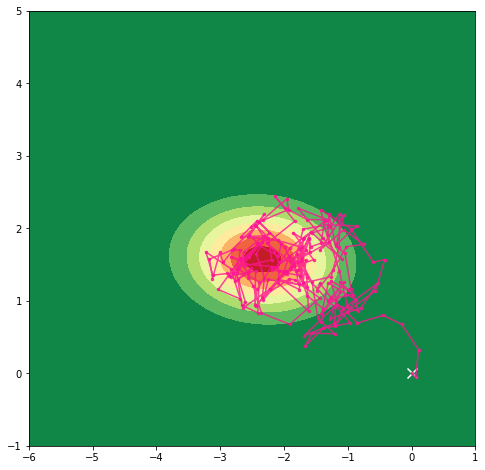

In [114]:
plt.figure(figsize=(8,8))
plt.contourf(w_0,w_1,pr*lk, cmap='RdYlGn_r')
plt.plot(w0[:200,0], w0[:200,1],".-", markersize=5, alpha=0.8, color="deeppink")
plt.scatter(w0[0,0], w0[0,1],marker="x", s=100, c="white")
plt.show()

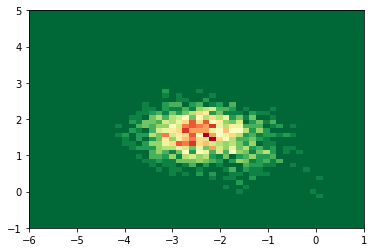

In [111]:
h = plt.hist2d(w0[:,0],w0[:,1], bins=50, density=True, range=[[-6,1],[-1,5]], cmap='RdYlGn_r')
# plt.close()

In [108]:
hist, x_edge, y_edge, _ = h

In [109]:
x_edge.shape

(51,)

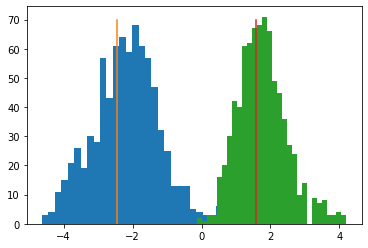

In [63]:
plt.hist(w0[:,0], bins=30)
plt.plot(w_ml[0]*np.ones(10), np.linspace(0,70,10))
plt.hist(w0[:,1], bins=30)
plt.plot(w_ml[1]*np.ones(10), np.linspace(0,70,10))
plt.show()

In [65]:
w_ml

array([-2.46636867,  1.5886689 ])

In [64]:
w0.mean(axis=0)

array([-2.17644735,  1.76610728])

In [39]:
np.cov(w0.T)

array([[ 1.24691718, -0.41705029],
       [-0.41705029,  0.44593281]])

In [40]:
m0

array([0, 1])

In [41]:
pr = stats.multivariate_normal.pdf(w,mean=m0, cov=S0)
beta=0.2
lk = likelihood(w, data_y, data_PHI, beta)

In [42]:
pr=np.outer(stats.gennorm.pdf(w_0, loc=m0[0], scale=4, beta=2.5), stats.gennorm.pdf(w_1, loc=m0[1], scale=10, beta=1.5))

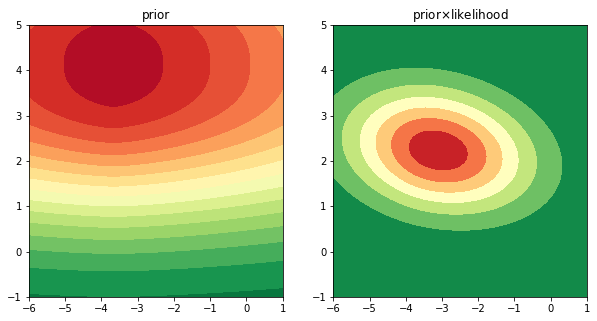

In [43]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.contourf(w_0,w_1,pr, cmap='RdYlGn_r', levels=15)
plt.title("prior")
plt.subplot(122)
plt.contourf(w_0,w_1,pr*lk, cmap='RdYlGn_r')
plt.title(r"prior$\times$likelihood")
plt.show()

In [44]:
delta=0.5
w0 = np.array([0.0, 0.0])[np.newaxis]
def posterior(w, PHI, y, beta, m0, S0):
    return likelihood(w, y, PHI, beta)*np.outer(stats.gennorm.pdf(w[0], loc=m0[0], scale=4, beta=2.5), stats.gennorm.pdf(w[1], loc=m0[1], scale=10, beta=1.5))
for _ in range(2000):
    candidate = w0[-1]+stats.uniform.rvs(loc=-delta, scale=2*delta, size=2)
    alpha = min(1, posterior(candidate, data_PHI, data_y, beta, m0, S0)/posterior(w0[-1], data_PHI, data_y, beta, m0, S0))
    u = stats.uniform.rvs()
    if u < alpha:
        w0 = np.vstack((w0, candidate))

In [45]:
w_0 = np.linspace(np.min(w0[:,0]),np.max(w0[:,0]),100)
w_1 = np.linspace(np.min(w0[:,1]),np.max(w0[:,1]),100)
# w_1 = np.linspace(-1, 5 ,100)
w=np.array([[[val0,val1] for val0 in w_0] for val1 in w_1])
posterior = likelihood(w, data_y, data_PHI, beta)*np.outer(stats.gennorm.pdf(w_0, loc=m0[0], scale=4, beta=2.5), stats.gennorm.pdf(w_1, loc=m0[1], scale=10, beta=1.5))

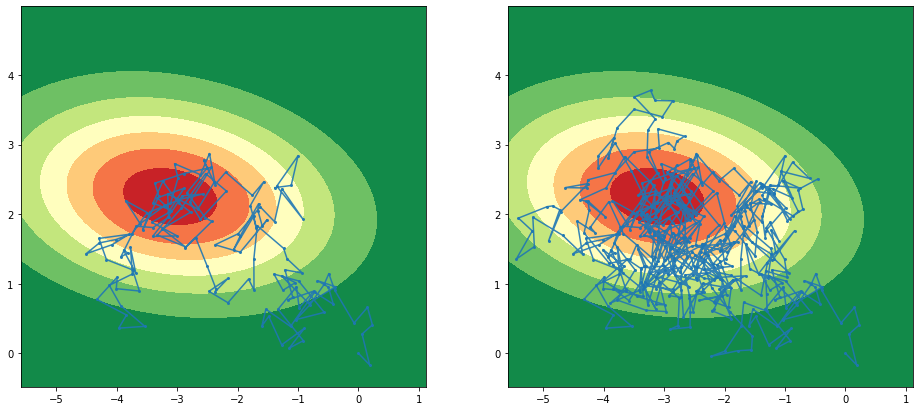

In [46]:
plt.figure(figsize=(16,7))
plt.subplot(121)
plt.contourf(w_0,w_1,posterior, cmap='RdYlGn_r')
plt.plot(w0[:150,0], w0[:150,1],"-o", markersize=2, alpha=0.9)
plt.subplot(122)
plt.contourf(w_0,w_1,posterior, cmap='RdYlGn_r')
plt.plot(w0[:500,0], w0[:500,1],"-o", markersize=2, alpha=0.9)
plt.show()

In [ ]:
plt.hist(w0[:,0], bins=40)
plt.show()

In [ ]:
w0.mean(axis=0)

In [136]:
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
camera = Camera(fig)
for i in range(10):
    plt.contourf(w_0,w_1,pr*lk, cmap='RdYlGn_r')
    plt.plot(w0[:10+i*100,0], w0[:10+i*100,1],".-", markersize=5, alpha=0.8, color="deeppink")
    plt.scatter(w0[0,0], w0[0,1],marker="x", s=100, c="white")
    # plt.plot([i] * 10)
    camera.snap()
animation = camera.animate()
plt.close()
HTML(animation.to_html5_video())